# <center>Boosting</center>
# <center>Часть 1. AdaBoost</center>

Пусть у нас имеется задача бинарной классификации и мы хотим использовать ансамбль таких слабых предсказателей, как деревья принятия решений с глубиной 1.
<img src='https://habrastorage.org/web/d28/78f/7ba/d2878f7bad0340fc8002e5ba6d0879a5.jpg' width=60%>

На каждой итерации увеличиваем веса объектов обучающей выборки, на которых ошиблись. Итоговая модель является взвешенной суммой слабых моделей:

<img src='https://habrastorage.org/web/b2b/029/d89/b2b029d898f64bbbb158e15d29595969.png' width=60%>

Алгоритм:
- Initialize sample weights $\Large w_i^{(0)} = \frac{1}{l}, i = 1, \dots, l$.
- For all $t = 1, \dots, T$
    * Train base algo $\Large b_t$, let $\epsilon_t$ be it's training error.
    * $\Large \alpha_t = \frac{1}{2}ln\frac{1 - \epsilon_t}{\epsilon_t}$.
    * Update sample weights: $\Large w_i^{(t)} = w_i^{(t-1)} e^{-\alpha_t y_i b_t(x_i)}, i = 1, \dots, l$.
    * Normalize sample weights: $\Large w_0^{(t)} = \sum_{j = 1}^k w_j^{(t)}, w_i^{(t)} = \frac{w_i^{(t)}}{w_0^{(t)}}, i = 1, \dots, l$.
- Return $\sum_t^{T}\alpha_tb_t$

## Пример применения для задачи регрессии

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rng = np.random.RandomState(1)
X = np.linspace(0, 6, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0]) # создадим некоторую выборку

In [2]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

regr_1 = DecisionTreeRegressor(max_depth=4) # обучим одну слабую модель

regr_2 = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=rng
) # и посмотрим чего можно добиться с помощью AdaBoost

regr_1.fit(X, y)
regr_2.fit(X, y)

y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

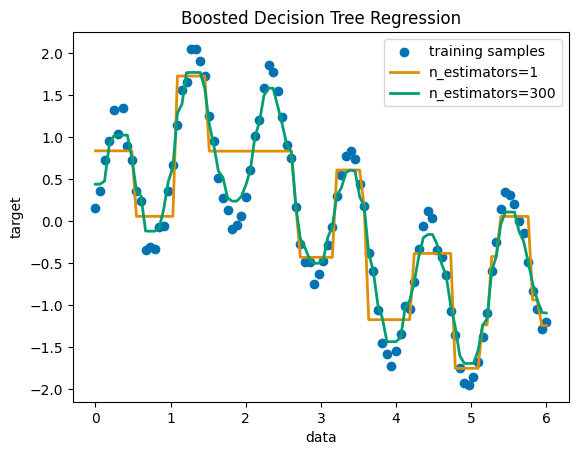

In [3]:


colors = sns.color_palette("colorblind")

plt.figure()
plt.scatter(X, y, color=colors[0], label="training samples")
plt.plot(X, y_1, color=colors[1], label="n_estimators=1", linewidth=2)
plt.plot(X, y_2, color=colors[2], label="n_estimators=300", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend()
plt.show()

# <center>Часть 2. Gradient Tree Boosting</center>

In [4]:
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

diabetes = datasets.load_diabetes() # загрузим готовый датасет
X, y = diabetes.data, diabetes.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=121
)

params = {
    "n_estimators": 500, # количество итераций градиентного бустинга
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 3473.9473


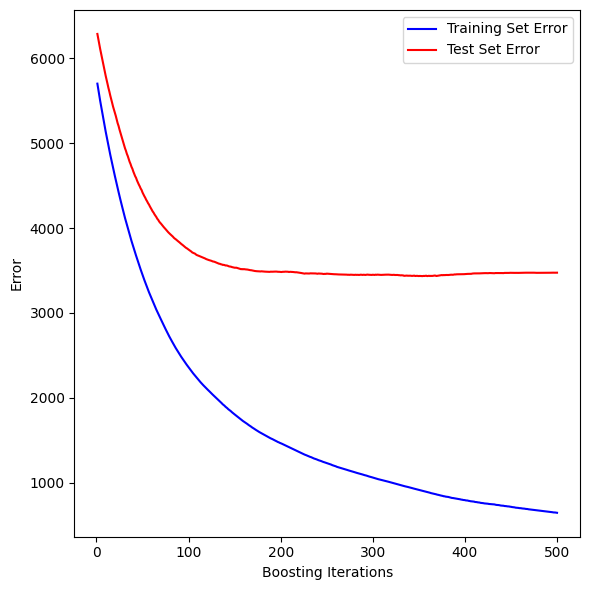

In [5]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Error",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Error"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Error")
fig.tight_layout()
plt.show()

## Bagging vs Boosting


1. **Bagging** простейший способ комбинировать однотипные предсказания, а **Boosting** - способ комбинирования предсказаний разного типа.
  
2. **Bagging** нацелен на уменьшение разброса ошибки, но не смещения, а **Boosting** предназначен для уменьшения смещения, но не разброса.
  
3. В **Bagging** веса у моделей одинаковые, а в **Boosting** веса моделей зависят от их качества.
  
4. В **Bagging** каждая модель строится независимо (параллельно), а в **Boosting** очередная модель зависит от предсказаний предыдущих.
  
5. В **Bagging** каждая модель получает случайную подвыборку из обучающей выборки с помощью **Bootstrap**. А в **Boosting** очередная модель обучается на объектах из обучающей выборки, на которых ошиблись предыдущие модели.
  
6. **Bagging** пытается решить проблему переобучения, в то время как **Boosting** пытается улучшить предсказания за счет уменьшения смещения ошибки.

7. Например, если классификатор нестабилен (высокий разброс ошибки), тогда следует применить **Bagging**. Если классификатор стабилен, но слишком прост для рассматриваемых данных (высокое смещение ошибки), тогда следует применить **Boosting**.

# <center>Часть 3. XGBoost, LightGBM, and Catboost</center>

Хорошая статья со сравнением: https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db

В sklearn также имеются реализации **HistGradientBoostingRegressor** и **HistGradientBoostingClassifier**, вдохновлённые реализацией из **LightGBM**, которые работают существенно быстрее для выборок размера больше **10000**.

## Чтение данных

Возьмём датасет поведения клиентов телекоммуникационной компании, который можно скачать [тут](https://www.kaggle.com/datasets/blastchar/telco-customer-churn).

Будем решать задачу предсказания собирается ли клиент перестать пользоватся услугами компании и, например, уйти к конкурентам. Это задача классификации, результирующую модель можно использовать для разработки целенаправленных программ по удержанию клиентов.

Датасет содержит:
- **Churn** ––– ушли ли клиенты в течение последнего месяца (целевой признак)
- Подписки клиента на разных сервисы ––– phone, multiple lines, internet, online security, online backup, device protection, tech support, streaming TV and movies
- Информация об аккаунте клиента ––– how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Демографическая информация о клиенте ––– gender, age range, and if they have partners and dependents

In [6]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

df = pd.read_csv("../../data/telecom/telecom.csv")
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [7]:
from sklearn.preprocessing import OneHotEncoder # закодируем категориальные нецелвые признаки

df = df.drop(["State"], axis=1) # много значений штатов, уберём, но в будущем можно попробовать оставить

enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(df[['International plan', 'Voice mail plan']]).toarray())
enc_df.columns = enc.get_feature_names(['International plan', 'Voice mail plan']) # дадим понятные имена колонкам

df.drop(['International plan', 'Voice mail plan'] ,axis=1, inplace=True) # удалим старые

df = df.join(enc_df)
df

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,...,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn,International plan_No,International plan_Yes,Voice mail plan_No,Voice mail plan_Yes
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,...,11.01,10.0,3,2.70,1,False,1.0,0.0,0.0,1.0
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,...,11.45,13.7,3,3.70,1,False,1.0,0.0,0.0,1.0
2,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,...,7.32,12.2,5,3.29,0,False,1.0,0.0,1.0,0.0
3,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,...,8.86,6.6,7,1.78,2,False,0.0,1.0,1.0,0.0
4,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,...,8.41,10.1,3,2.73,3,False,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,415,36,156.2,77,26.55,215.5,126,18.32,279.1,...,12.56,9.9,6,2.67,2,False,1.0,0.0,0.0,1.0
3329,68,415,0,231.1,57,39.29,153.4,55,13.04,191.3,...,8.61,9.6,4,2.59,3,False,1.0,0.0,1.0,0.0
3330,28,510,0,180.8,109,30.74,288.8,58,24.55,191.9,...,8.64,14.1,6,3.81,2,False,1.0,0.0,1.0,0.0
3331,184,510,0,213.8,105,36.35,159.6,84,13.57,139.2,...,6.26,5.0,10,1.35,2,False,0.0,1.0,1.0,0.0


In [8]:
y = df["Churn"].astype('int')
X = df.drop(["Churn"], axis=1)
X

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,International plan_No,International plan_Yes,Voice mail plan_No,Voice mail plan_Yes
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,1.0,0.0,0.0,1.0
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,1.0,0.0,0.0,1.0
2,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,1.0,0.0,1.0,0.0
3,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0.0,1.0,1.0,0.0
4,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,415,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,1.0,0.0,0.0,1.0
3329,68,415,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,1.0,0.0,1.0,0.0
3330,28,510,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,1.0,0.0,1.0,0.0
3331,184,510,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,0.0,1.0,1.0,0.0


In [9]:
y.mean()

0.14491449144914492

## CatBoost

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score

# сюда будем сохранять качество натренированных моделей
accuracy= [] 
recall =[]
roc_auc= []
precision = []

model_names =[]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

catboost_base = CatBoostClassifier(verbose=False,random_state=0)

catboost_base.fit(X_train, y_train,eval_set=(X_test, y_test))
y_pred = catboost_base.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names.append('Catboost_default')
result_df1 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df1

,Accuracy,Recall,Roc_Auc,Precision
Catboost_default,0.959,0.7273,0.8625,0.9811


## XGBoost

In [11]:
xgbc_base = XGBClassifier(random_state=0)

xgbc_base.fit(X_train, y_train)
y_pred = xgbc_base.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names.append('XGBoost_default')
result_df2 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df2

,Accuracy,Recall,Roc_Auc,Precision
Catboost_default,0.959,0.7273,0.8625,0.9811
XGBoost_default,0.953,0.7413,0.8648,0.9138


## LightGBM

In [12]:
lgbmc_base=LGBMClassifier(random_state=0)

lgbmc_base.fit(X_train, y_train,eval_set=(X_test, y_test),feature_name='auto', verbose=0)

y_pred = lgbmc_base.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names.append('LightGBM_default')
result_df3 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df3

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


,Accuracy,Recall,Roc_Auc,Precision
Catboost_default,0.959,0.7273,0.8625,0.9811
XGBoost_default,0.953,0.7413,0.8648,0.9138
LightGBM_default,0.951,0.6993,0.8461,0.9434


Конечно можно также подбирать оптимальные значения гиперпараметров для этих моделей. Например, можно использовать фреймворк **Optuna** (https://optuna.org/)